In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from datetime import date, datetime, timezone
import os
import warnings

import git
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import yaml

import pop_tools
import esmlab
import esmlab_regrid
print(esmlab_regrid.__version__) # Currently using ~/codes/esmlab_regrid (installed with pip -e from my fork)

from gen_remap_weights_1d import gen_remap_weights_1d
import config
import util

2019.5.2.dev10+gd602b1f.d20190920


In [3]:
# script identifier to go in generated file

repo = 'github.com/marbl-ecosys/marbl-forcing'
sha = git.Repo(search_parent_directories=True).head.object.hexsha
script_fname = 'initial_conditions/gen_mom6_omip_IC.ipynb'
id_string = f'{repo}/tree/{sha}/{script_fname}'

In [4]:
# input specifications

tracernames = [ 'TEMP', 'SALT',
    'NO3', 'PO4', 'SiO3', 'O2', 'DIC', 'ALK', 
    'spC', 'spChl', 'spFe', 'spP', 'spCaCO3', 
    'diatC', 'diatChl', 'diatFe', 'diatP', 'diatSi', 
    'diazC', 'diazChl', 'diazFe', 'diazP', 
    'zooC', 
    'DOC', 'DOCr', 'DON', 'DONr', 'DOP', 'DOPr', 'NH4', 
    'Fe', 'Lig'
]

# IC specified by OMIP (macronutrients, O2, DIC, ALK)
dirin_omip = '/glade/p/cesm/bgcwg/OMIPinit'
omip_metadata = {
    'TEMP':{'fname':'woa13_temperature_OMIPinit.nc', 'varname':'temp'},
    'SALT':{'fname':'woa13_salinity_OMIPinit.nc', 'varname':'salt'},
    'NO3':{'fname':'woa13_nitrate_OMIPinit.nc', 'varname':'no3'},
    'PO4':{'fname':'woa13_phosphate_OMIPinit.nc', 'varname':'po4'},
    'SiO3':{'fname':'woa13_silicate_OMIPinit.nc', 'varname':'si'},
    'O2':{'fname':'woa13_oxygen_OMIPinit.nc', 'varname':'o2'},
    'DIC':{'fname':'glodapv2_Ct_preind_OMIPinit.nc', 'varname':'Ct_preind'},
    'ALK':{'fname':'glodapv2_At_OMIPinit.nc', 'varname':'At'}
}

# Add grid name to metadata.
# This is fragile. It would be better to determine this automatically.
# Alternatively, the script would be more self contained if the grid were constructed on the fly.
omip_metadata['TEMP']['grid'] = 'latlon_1x1_180W'
omip_metadata['SALT']['grid'] = 'latlon_1x1_180W'
omip_metadata['NO3']['grid'] = 'latlon_1x1_180W'
omip_metadata['PO4']['grid'] = 'latlon_1x1_180W'
omip_metadata['SiO3']['grid'] = 'latlon_1x1_180W'
omip_metadata['O2']['grid'] = 'latlon_1x1_180W'
omip_metadata['DIC']['grid'] = 'latlon_1x1_20E'
omip_metadata['ALK']['grid'] = 'latlon_1x1_20E'

# get other tracers (living pools, DOM, NH4, Fe, Lig) from refcase
refcase = 'b.e21.B1850.f09_g17.CMIP6-piControl.001'
refdate = '0501-01-01'
dirin_refcase = f'{config.inputdata}/cesm2_init/{refcase}/{refdate}'
fname_refcase = f'{dirin_refcase}/{refcase}.pop.r.{refdate}-00000.nc'
print(fname_refcase)

/glade/p/cesmdata/cseg/inputdata/cesm2_init/b.e21.B1850.f09_g17.CMIP6-piControl.001/0501-01-01/b.e21.B1850.f09_g17.CMIP6-piControl.001.pop.r.0501-01-01-00000.nc


In [5]:
# details on file being generated

dst_grid = 'MOM_tx0.66v1'
ltripole = True
interp_method = 'bilinear'
datestamp = date.today().strftime("%y%m%d")
fname_out = f'{config.dirout}/ecosys_jan_IC_omip_{dst_grid}_c{datestamp}.nc'
print(fname_out)

/glade/work/mlevy/cesm_inputdata/ecosys_jan_IC_omip_MOM_tx0.66v1_c190920.nc


In [6]:
# start ds_out as Dataset of grid variables

ds_out = xr.open_dataset('/glade/p/cesmdata/cseg/mapping/grids/tx0.66v1_SCRIP_190314.nc')

# Vertical grid: need to define z_t, dz, and z_t_bounds
# Note that z_t_bounds can be determined from dz
# add z_t_bounds to SCRIP grid file
vert_grid_center = [2.5, 10, 20, 32.5, 51.25, 75, 100, 125, 156.25, 200, 250, 312.5, 400,
                    500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1537.5, 1750,
                    2062.5, 2500, 3000, 3500, 4000, 4500, 5000, 5500, 6000]
vert_grid_thick = np.array([5])
for center in vert_grid_center[1:]:
    dist_from_bottom = center - vert_grid_thick.sum()
    vert_grid_thick = np.append(vert_grid_thick, 2*dist_from_bottom)

z_t_edges = np.concatenate(([0.0], np.cumsum(vert_grid_thick)))
z_t_bounds_vals = np.stack((z_t_edges[:-1], z_t_edges[1:]), axis=1)
ds_out['z_t_bounds'] = xr.DataArray(z_t_bounds_vals, dims=('z_t', 'd2'),
                                   coords={'z_t':vert_grid_center})
ds_out['dz'] = xr.DataArray(vert_grid_thick, dims=('z_t'))

# update attrs
ds_out['z_t'].attrs['bounds'] = 'z_t_bounds'
ds_out['dz'].attrs['units'] = 'm'

inputdata = '/glade/p/cesmdata/cseg/inputdata/'
cell_depth = xr.open_dataset(inputdata+'ocn/mom/tx0.66v1/ocean_topog_190314.nc')['depth'].data
active_level_count = np.zeros(cell_depth.shape)
for k, depth in enumerate(vert_grid_center):
    active_level_count = np.where(cell_depth>=depth, k, active_level_count)


In [7]:
# generate output grid 3D mask

nk = len(ds_out.z_t)
ni, nj = ds_out.grid_dims.data

# make 3D array of 0:km
zero_to_km = xr.DataArray(np.arange(0, nk), dims=('z_t'))
ONES_3d = xr.DataArray(np.ones((nk, nj, ni)), dims=('z_t', 'nlat', 'nlon'))
ZERO_TO_KM = (zero_to_km * ONES_3d)

# mask out cells where k is below KMT
MASK = ZERO_TO_KM.where(ZERO_TO_KM < active_level_count)
MASK = xr.where(MASK.notnull(), True, False)
MASK['z_t'] = ds_out.z_t

In [8]:
ni, nj, nk

(540, 458, 34)

In [9]:
# Add MOM6 grid to regrid settings (super kludgy!)

with open('MOM_grid.yaml') as gridfile:
    MOM6_regrid = yaml.safe_load(gridfile)
regrid_settings = esmlab.config.get('regrid')
regrid_settings['grids']['MOM_tx0.66v1'] = MOM6_regrid
esmlab.config.set({'regrid' : regrid_settings});

USER = os.environ['USER']
print(regrid_settings['grids'].keys())

dict_keys(['POP-gx3v7', 'POP-gx1v6', 'POP-gx1v7', 'POP-tx1v1', 'POP-tx0.1v2', 'POP-tx0.1v2-62lev', 'POP-tx0.1v3', 'latlon-1x1-180W', 'latlon-0.25x0.25-180W', 'T62', 'CAM-f09', 'MOM_tx0.66v1'])


In [10]:
for tracername in omip_metadata:
    # decode_times=False because omip files have unsupported units
    #     "months since 0000-01-01 00:00:00"
    ds_omip = xr.open_dataset(dirin_omip+'/'+omip_metadata[tracername]['fname'], decode_times=False)

    varname_omip = omip_metadata[tracername]['varname']

    src_grid = omip_metadata[tracername]['grid']
    print(f'regridding {tracername} from {src_grid} to {dst_grid}')

    # perform lateral remapping
    regrid_operator = esmlab_regrid.regridder(
        name_grid_src=omip_metadata[tracername]['grid'], 
        name_grid_dst=dst_grid, method=interp_method, overwrite_existing=False)
    tracer_omip = ds_omip[varname_omip]
    if 'time' in tracer_omip.dims:
        tracer_omip = tracer_omip.isel(time=0, drop=True)
    tracer_lateral_regrid = regrid_operator(tracer_omip, renormalize=True)

    # generate vertical remapping weights
    depth_name_in = tracer_omip.dims[0]
    depth_bounds_name = ds_omip[depth_name_in].attrs['bounds']
    depth_remap_weights = gen_remap_weights_1d(
        ds_omip[depth_bounds_name], ds_out['z_t_bounds'],
        ds_omip[depth_name_in].attrs['units'], ds_out.dz.attrs['units'])

    # perform vertical remapping
    nk_in = tracer_lateral_regrid.shape[0]
    tracer_lateral_regrid_flat = tracer_lateral_regrid.values.reshape((nk_in, nj*ni))
    tracer_full_regrid_flat = depth_remap_weights.dot(tracer_lateral_regrid_flat)
    tracer_full_regrid_values = tracer_full_regrid_flat.reshape((nk, nj, ni))
    tracer_full_regrid = xr.DataArray(tracer_full_regrid_values, dims=('z_t', 'nlat', 'nlon'),
                                      coords={'z_t':ds_out.z_t}, attrs=tracer_omip.attrs)
    tracer_full_regrid = tracer_full_regrid.where(MASK)
    tracer_full_regrid.encoding['_FillValue'] = tracer_omip.encoding['_FillValue']
    
    # perform lateral fill (need in mom_tools!)
    tracer_full_regrid = pop_tools.lateral_fill(tracer_full_regrid, MASK, ltripole=ltripole)

    # perform vertical fill
    unfilled = tracer_full_regrid.isnull() & (MASK == 1.)                    
    if unfilled.any():
        for k in range(1, nk):
            tracer_full_regrid[k, :, :] = xr.where(unfilled[k, :, :],
                                                   tracer_full_regrid[k-1, :, :],
                                                   tracer_full_regrid[k, :, :])
        if (tracer_full_regrid.isnull() & (MASK == 1.)).any():
            warnings.warn(f'{tracername} still has missing values')

    ds_out[tracername] = tracer_full_regrid
ds_out

regridding TEMP from latlon_1x1_180W to MOM_tx0.66v1
regridding SALT from latlon_1x1_180W to MOM_tx0.66v1
regridding NO3 from latlon_1x1_180W to MOM_tx0.66v1
regridding PO4 from latlon_1x1_180W to MOM_tx0.66v1
regridding SiO3 from latlon_1x1_180W to MOM_tx0.66v1
regridding O2 from latlon_1x1_180W to MOM_tx0.66v1
regridding DIC from latlon_1x1_20E to MOM_tx0.66v1
regridding ALK from latlon_1x1_20E to MOM_tx0.66v1


<xarray.Dataset>
Dimensions:          (d2: 2, grid_corners: 4, grid_rank: 2, grid_size: 247320, nlat: 458, nlon: 540, z_t: 34)
Coordinates:
  * z_t              (z_t) float64 2.5 10.0 20.0 32.5 ... 5e+03 5.5e+03 6e+03
Dimensions without coordinates: d2, grid_corners, grid_rank, grid_size, nlat, nlon
Data variables:
    grid_dims        (grid_rank) int32 540 458
    grid_center_lat  (grid_size) float64 ...
    grid_center_lon  (grid_size) float64 ...
    grid_imask       (grid_size) int32 ...
    grid_corner_lat  (grid_size, grid_corners) float64 ...
    grid_corner_lon  (grid_size, grid_corners) float64 ...
    grid_area        (grid_size) float64 ...
    z_t_bounds       (z_t, d2) float64 0.0 5.0 5.0 ... 5.75e+03 6.25e+03
    dz               (z_t) float64 5.0 10.0 10.0 15.0 ... 500.0 500.0 500.0
    TEMP             (z_t, nlat, nlon) float64 nan nan nan nan ... nan nan nan
    SALT             (z_t, nlat, nlon) float64 nan nan nan nan ... nan nan nan
    NO3              (z_t, nlat, 

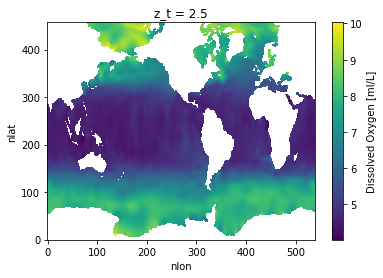

In [11]:
ds_out['O2'].isel(z_t=0).plot()

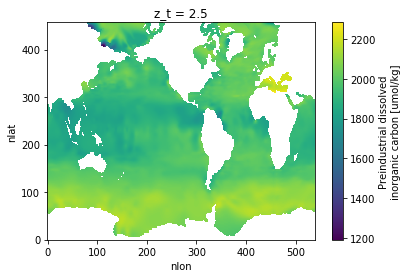

In [12]:
ds_out['DIC'].isel(z_t=0).plot()

In [ ]:
# special treatment of DIC and ALK in marginal seas
SALT = ds_out.SALT
DIC = ds_out.DIC
ALK = ds_out.ALK
rho_0 = 1.026

# Black Sea
# fit by eye from Fig 6 of Goyet, Bradshaw, Brewer
# The carbonate system in the Black Sea
# Deep-Sea Research, part A, Vol 38, Suppl 2, 1991, pp. S1049-S1068
MASK_fit = MASK & (ds_out.REGION_MASK == -13) & (SALT <= 21.0)
ALK = xr.where(MASK_fit, 3250.0, ALK)
DIC = xr.where(MASK_fit, 3250.0, DIC)
MASK_fit = MASK & (ds_out.REGION_MASK == -13) & (SALT <= 19.5)
DIC = xr.where(MASK_fit, 3000.0 + (SALT - 18) / (19.5 - 18) * (3250 - 3000), DIC)
MASK_fit = MASK & (ds_out.REGION_MASK == -13) & (SALT > 21.0)
ALK = xr.where(MASK_fit, 3300.0 + (SALT - 21) / (22.3 - 21) * (4500 - 3300), ALK)
DIC = xr.where(MASK_fit, (ALK + 1000) / 1.32, DIC)

# Baltic Sea
# Hjalmarsson et al, Distribution, long-term development and mass
# balance calculation of total alkalinity in the Baltic Sea,
# Continental Shelf Research, Vol 28, 2008, pp. 593-601
# linear fits from Table 2
# one fit for psu < 7.3 for Gulf of Bothnia and Bothnian Sea
# another fit for Baltic Proper
# ignore values from Gulf of Finland and Gulf of Riga
# paper reports in umol/L, convert to umol/kg
MASK_fit = MASK & (ds_out.REGION_MASK == -12) & (SALT <= 7.3)
ALK = xr.where(MASK_fit, (119.0 + 196.0 * SALT) / rho_0, ALK)
DIC = xr.where(MASK_fit, ALK / 1.01, DIC)
MASK_fit = MASK & (ds_out.REGION_MASK == -12) & (SALT > 7.3)
ALK = xr.where(MASK_fit, (1237.0 + 43.0 * SALT) / rho_0, ALK)
DIC = xr.where(MASK_fit, ALK / 1.01, DIC)

ds_out['DIC'].values = DIC.values
ds_out['ALK'].values = ALK.values

In [ ]:
# change units of omip vars to model units
for tracername in omip_metadata:
    units = ds_out[tracername].attrs['units']
    if 'kg' in units:
        ds_out[tracername].values *= rho_0
        ds_out[tracername].attrs['units'] = units.replace('kg', 'L')
        ds_out[tracername].attrs['rho_0'] = rho_0
    if tracername == 'O2' and (units == 'ml/L' or units == 'milliliters_per_liter'):
        ds_out[tracername].values *= (1.0e3 / 22.3916)
        ds_out[tracername].attrs['units'] = 'umol/L'

In [13]:
# copy from refcase restart file to ds_out tracers not yet in ds_out

fillvalue = -1.0e34 # value to replace land values with

ds_refcase = xr.open_dataset(fname_refcase).rename({'k':'z_t', 'j':'nlat', 'i':'nlon'})
# Will need vertical interpolation as well as horizontal!
# ds_refcase['z_t'] = ds_out['z_t']
for tracername in tracernames:
    if tracername not in ds_out.data_vars:
        print(f'need to include {tracername} from {refcase} restart file')
#         tracer = ds_refcase[tracername+'_CUR']
#         tracer = tracer.where(MASK)
#         # Set floor values that are 0.0 to value 1 layer shallower.
#         # This is to fill in values where KMT was popped up by overflow parameterization.
#         # This is needed to enable using ds_out in runs where overflows are disabled.
#         for k in range(1, nk):
#             tracer[k, :, :] = xr.where((tracer[k, :, :] == 0.0) & (k+1 == ds_out.KMT),
#                                        tracer[k-1, :, :], tracer[k, :, :])
#         tracer.attrs['coordinates'] = 'TLONG TLAT z_t'
#         tracer.encoding['_FillValue'] = fillvalue
#         ds_out[tracername] = tracer

need to include spC from b.e21.B1850.f09_g17.CMIP6-piControl.001 restart file
need to include spChl from b.e21.B1850.f09_g17.CMIP6-piControl.001 restart file
need to include spFe from b.e21.B1850.f09_g17.CMIP6-piControl.001 restart file
need to include spP from b.e21.B1850.f09_g17.CMIP6-piControl.001 restart file
need to include spCaCO3 from b.e21.B1850.f09_g17.CMIP6-piControl.001 restart file
need to include diatC from b.e21.B1850.f09_g17.CMIP6-piControl.001 restart file
need to include diatChl from b.e21.B1850.f09_g17.CMIP6-piControl.001 restart file
need to include diatFe from b.e21.B1850.f09_g17.CMIP6-piControl.001 restart file
need to include diatP from b.e21.B1850.f09_g17.CMIP6-piControl.001 restart file
need to include diatSi from b.e21.B1850.f09_g17.CMIP6-piControl.001 restart file
need to include diazC from b.e21.B1850.f09_g17.CMIP6-piControl.001 restart file
need to include diazChl from b.e21.B1850.f09_g17.CMIP6-piControl.001 restart file
need to include diazFe from b.e21.B18

In [ ]:
# set derived quantities

ds_out['DIC_ALT_CO2'] = ds_out['DIC']
ds_out['ALK_ALT_CO2'] = ds_out['ALK']
DOCtot = ds_out['DOC'].copy()
DOCtot.values = ds_out['DOC'].values + ds_out['DOCr'].values
DOCtot.attrs['long_name'] = 'DOC + DOCr'
ds_out['DOCtot'] = DOCtot

In [ ]:
# write generated file

datestamp = datetime.now(timezone.utc).strftime("%Y-%m-%d")
ds_out.attrs['history'] = f'created by {id_string} on {datestamp}'
omip_file_list = [dirin_omip+'/'+omip_metadata[varname]['fname'] for varname in omip_metadata]
ds_out.attrs['input_file_list'] = ' '.join(omip_file_list + [fname_refcase])
util.ds_clean(ds_out).to_netcdf(fname_out)